In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import itertools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [ ]:
data_type = {'MM.YYYY' : np.str}
df = pd.read_excel(r'/.xlsx', sheet_name='', dtype=data_type)
df.head()

In [ ]:
df = df[['Product', 'MM.YYYY', 'Type', 'Price']]
df.dtypes

In [ ]:
df['MM.YYYY'] = pd.to_datetime(df['MM.YYYY'], format = '%m.%Y')
df['MM.YYYY'].min(), df['MM.YYYY'].max()

In [ ]:
df = df[['Product', 'MM.YYYY', 'Price']].groupby(['Product', 'MM.YYYY']).sum().reset_index()
df_index = df.set_index('MM.YYYY')
df_index.index

In [8]:
df_reg1 = df_index[df_index["Product"] == "product 1"]["Price"]
df_reg2 = df_index[df_index["Product"] == "product 2"]["Price"]
df_reg3 = df_index[df_index["Product"] == "product 3"]["Price"]

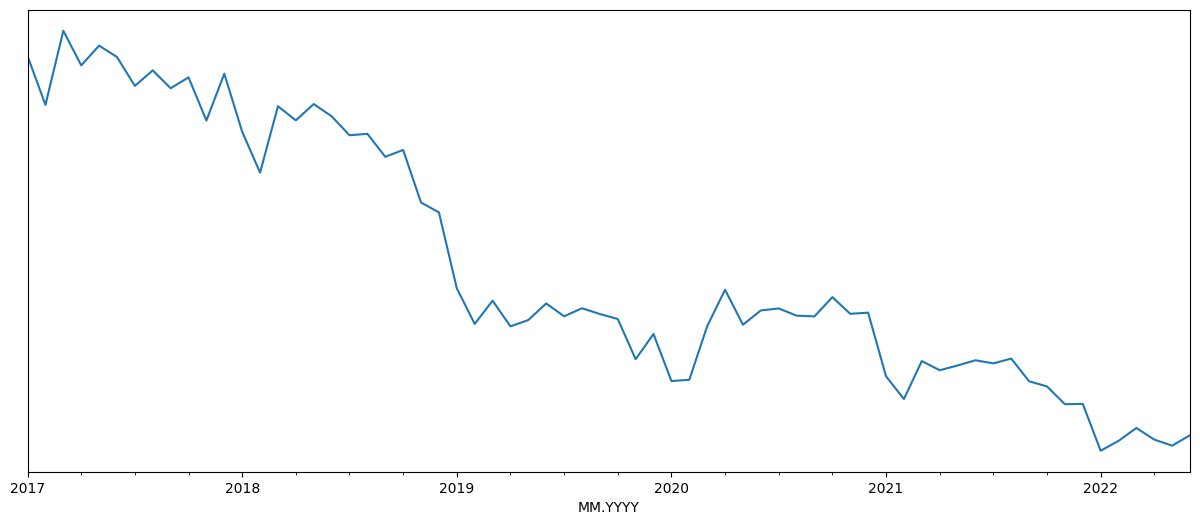

<Figure size 640x480 with 0 Axes>

In [118]:
df_reg1.plot(figsize=(15, 6))
plt.yticks([])
plt.show()
plt.savefig("r_1.png", dpi = 100)

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df_reg1, model='additive')
fig = decomposition.plot()
plt.show()
plt.savefig("r_1_decomp.png")

In [33]:
test = sm.tsa.adfuller(df_reg1)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('not stationary')
else:
    print('stationary')

adf:  -1.1826067473375663
p-value:  0.6810327435767608
Critical values:  {'1%': -3.5352168748293127, '5%': -2.9071540828402367, '10%': -2.5911025443786984}
Ряд не стационарен


([], [])

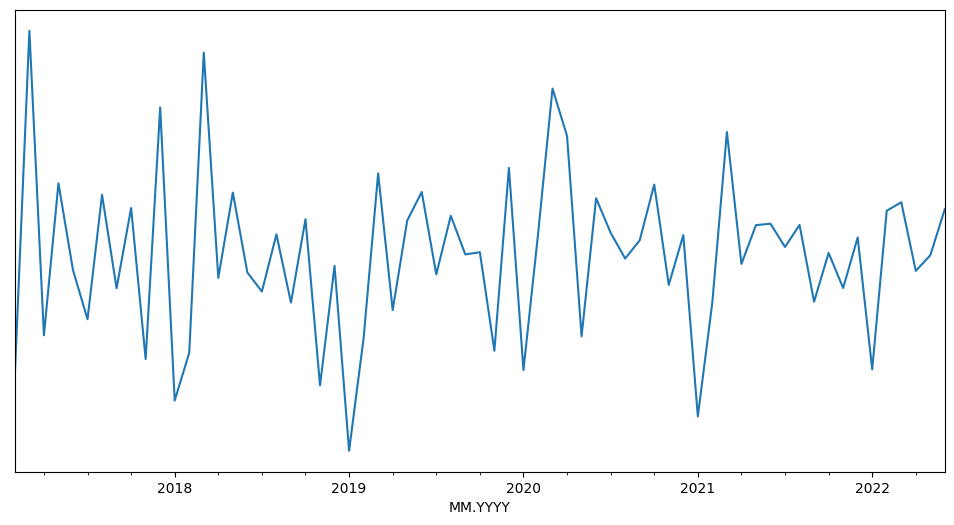

In [35]:
otg1diff = df_reg1.diff(periods=1).dropna()
otg1diff.plot(figsize=(12,6))
plt.yticks([])

In [36]:
test = sm.tsa.adfuller(otg1diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('not stationary')
else:
    print('stationary')

adf:  -1.2888207118922215
p-value:  0.6342712057092424
Critical values:  {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}
Ряд не стационарен


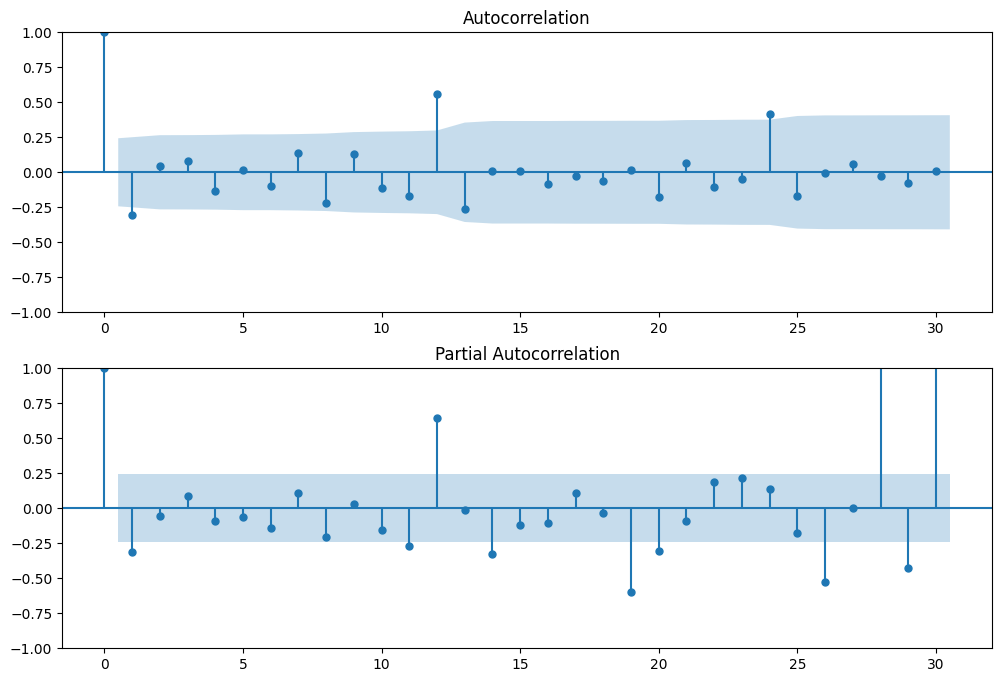

In [38]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otg1diff.values.squeeze(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otg1diff, lags=30, ax=ax2)

In [39]:
otg1diff = otg1diff.diff(periods=12).dropna()

In [40]:
test1 = sm.tsa.adfuller(otg1diff)
print('adf: ', test1[0])
print('p-value: ', test1[1])
print('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']:
    print('not stationary')
else:
    print('stationary')


adf:  -3.961604960318004
p-value:  0.0016254553953114449
Critical values:  {'1%': -3.60098336718852, '5%': -2.9351348158036012, '10%': -2.6059629803688282}
единичных корней нет, ряд стационарен


#Model SARIMAX, product 1

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

lst = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_reg1, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit(disp=0)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
          continue

print(lst)

In [ ]:
model_11 = sm.tsa.statespace.SARIMAX(df_reg1,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_11 = model_11.fit(disp=0)
print(results_11.summary().tables[1])

In [ ]:
results_11.plot_diagnostics(figsize=(16, 8))
plt.show()

#Compare

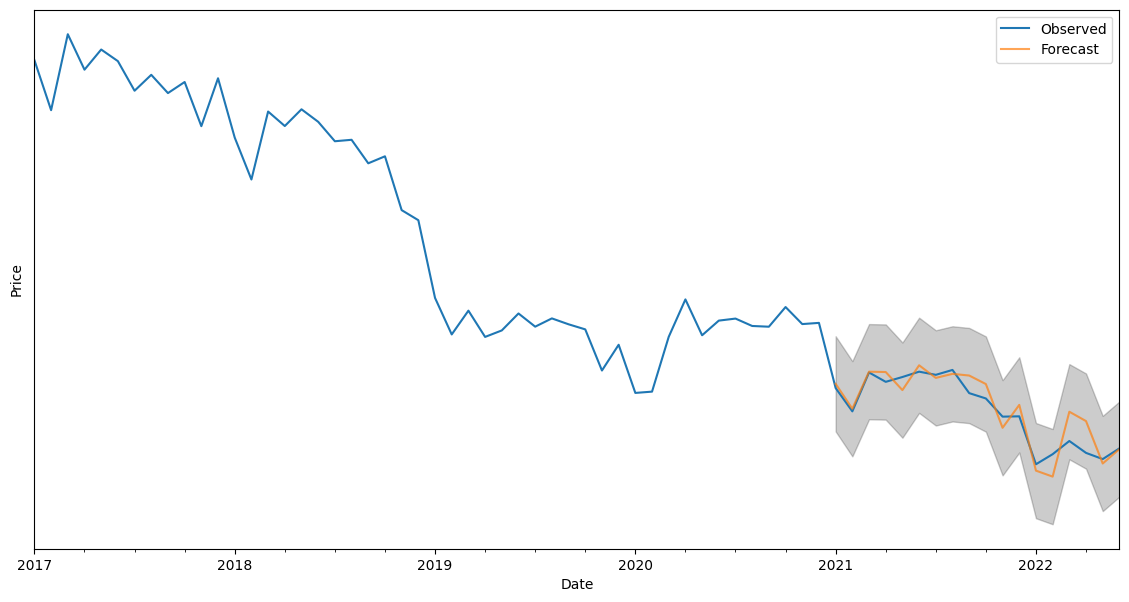

<Figure size 640x480 with 0 Axes>

In [44]:
pred = results_11.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_reg1['2017':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.yticks([])
plt.show()
plt.savefig("r_11_comp.png")

#Metrics

In [45]:
y_forecasted = pred.predicted_mean
y_truth = df_reg1['2021-01-01':]

In [47]:
mse_model_11 = mean_squared_error(y_forecasted, y_truth)
print('MSE: {}'.format(mse_model_11))

MSE: 182566982950.17502


In [49]:
rmse_model_11 = mean_squared_error(y_forecasted, y_truth, squared=False)
print('RMSE: {}'.format(rmse_model_11))

RMSE: 427278.5776869407


In [50]:
r2_model_11 = r2_score(y_truth,y_forecasted)
print("R2: {}".format(r2_model_11))

R2: 0.8233032943652043


#Forecast

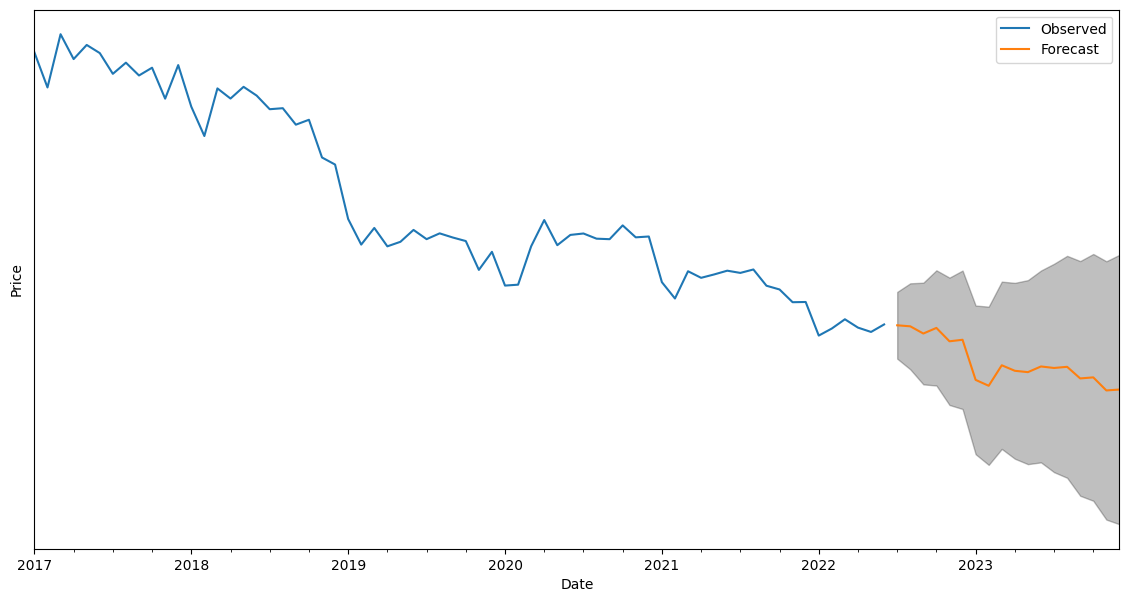

<Figure size 640x480 with 0 Axes>

In [51]:
pred_uc = results_11.get_forecast(steps=18)
pred_ci = pred_uc.conf_int()
ax = df_reg1.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.yticks([])
plt.show()
plt.savefig("r_11_prd.png")

#Model Prophet, product 1

In [52]:
df_reg1_pr = df[df["Product"] == "product 1"][["MM.YYYY", "Price"]]

In [53]:
df_reg1_pr = df_reg1_pr.rename(columns={'MM.YYYY': 'ds', 'Price': 'y'})
model_12 = Prophet(interval_width=0.95)
model_12.fit(df_reg1_pr)

reg1_forecast = model_12.make_future_dataframe(periods=18, freq='MS')
reg1_forecast = model_12.predict(reg1_forecast)

17:51:57 - cmdstanpy - INFO - Chain [1] start processing
17:51:58 - cmdstanpy - INFO - Chain [1] done processing


#Forecast

<Figure size 1800x600 with 0 Axes>

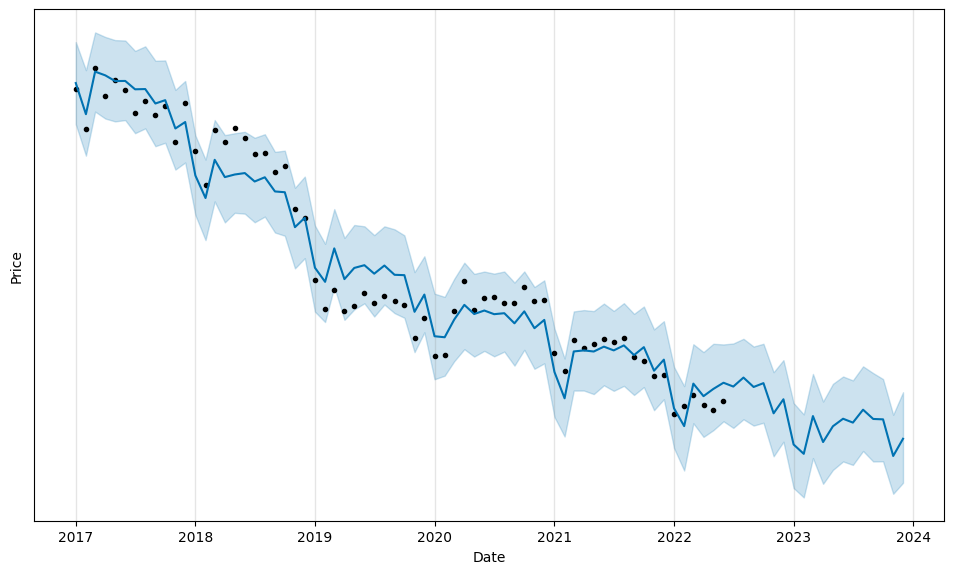

In [54]:
plt.figure(figsize=(18, 6))
model_12.plot(reg1_forecast, xlabel = 'Date', ylabel = 'Price')
plt.yticks([])
plt.savefig("r_21_pred.png")

#Compare

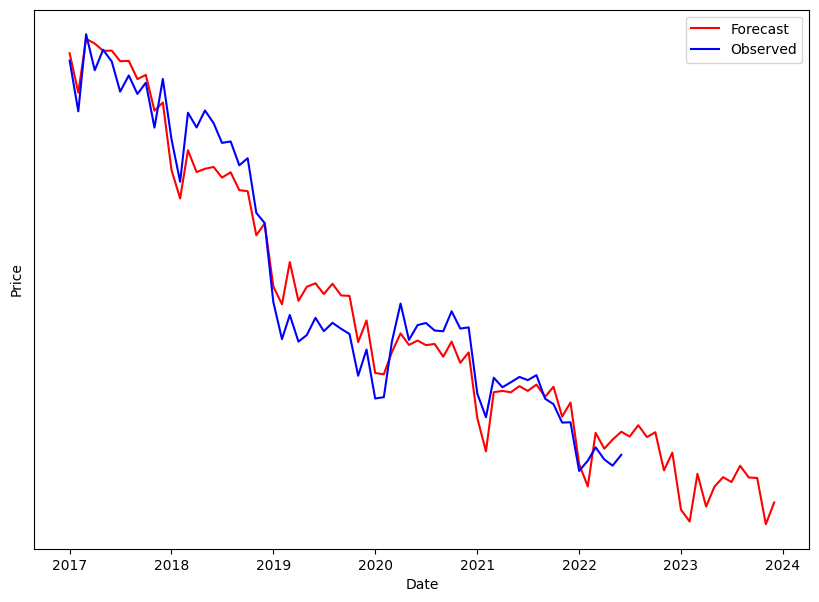

In [55]:
plt.figure(figsize=(10, 7))
plt.plot(reg1_forecast['ds'], reg1_forecast['yhat'], 'r-', label='Forecast')
plt.plot(df_reg1_pr['ds'], df_reg1_pr['y'], 'b-', label='Observed')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Price')
plt.yticks([])
plt.savefig("r_12_comp.png")

#Metrics

In [56]:
metric_df = reg1_forecast.set_index('ds')[['yhat']].join(df_reg1_pr.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

In [57]:
mse_model_12 = mean_squared_error(metric_df.y, metric_df.yhat)
print('MSE: {}'.format(mse_model_12))

MSE: 630965580360.1533


In [58]:
rmse_model_12 = mean_squared_error(metric_df.y, metric_df.yhat, squared=False)
print('RMSE: {}'.format(rmse_model_12))

RMSE: 794333.4188866494


In [59]:
r2_model_12 = r2_score(metric_df.y, metric_df.yhat)
print('R2: {}'.format(r2_model_12))

R2: 0.9594250205778208


#Product 2

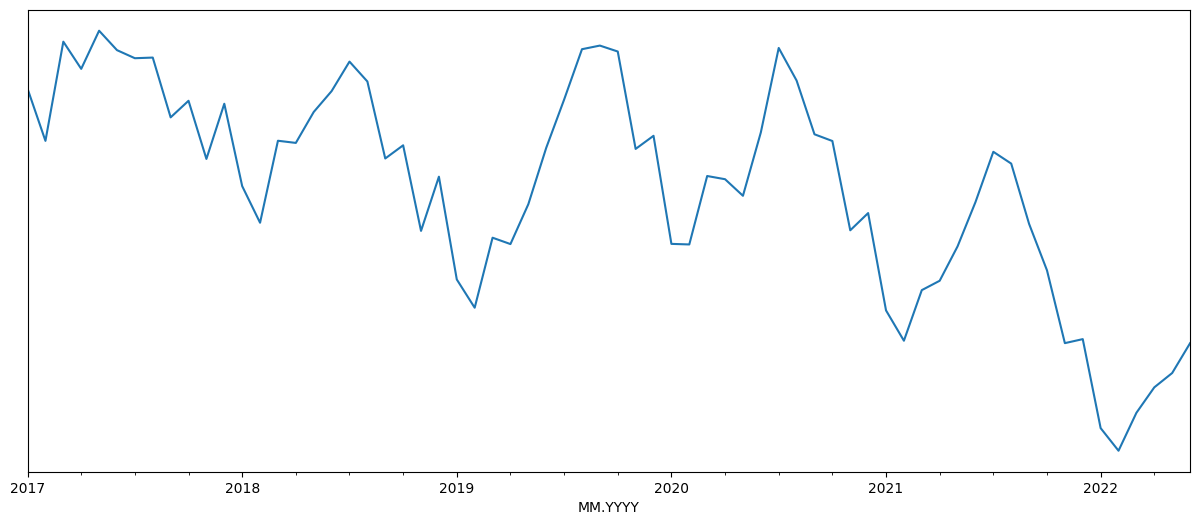

<Figure size 640x480 with 0 Axes>

In [111]:
df_reg2.plot(figsize=(15, 6))
plt.yticks([])
plt.show()
plt.savefig("r_21.png")

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df_reg2, model='additive')
fig = decomposition.plot()
plt.show()
plt.savefig("r_21_dec.png")

In [61]:
test = sm.tsa.adfuller(df_reg2)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('not stationary')
else:
    print('stationary')

adf:  0.7776814024036695
p-value:  0.9912672272153639
Critical values:  {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}
Ряд не стационарен


([], [])

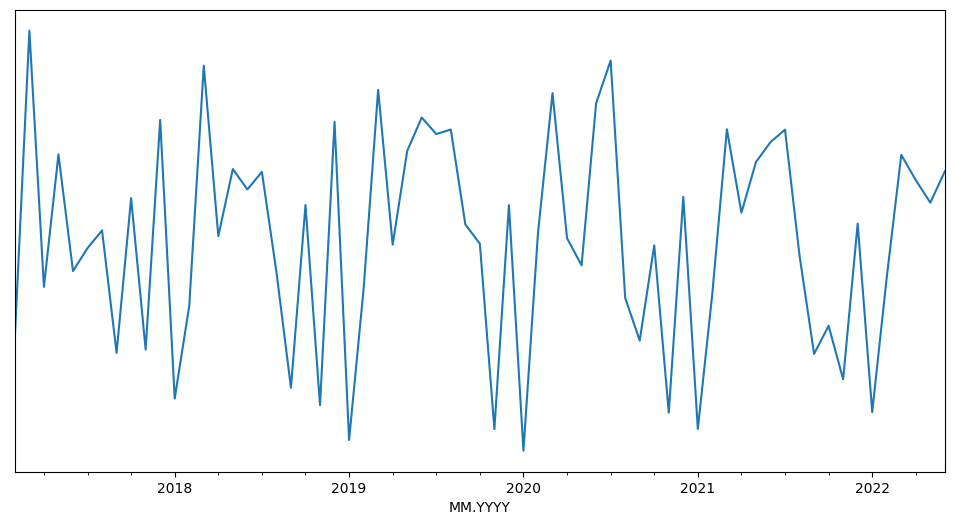

In [62]:
otg2diff = df_reg2.diff(periods=1).dropna()
otg2diff.plot(figsize=(12, 6))
plt.yticks([])

In [ ]:
test = sm.tsa.adfuller(otg2diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']:
    print('not stationary')
else:
    print('stationary')

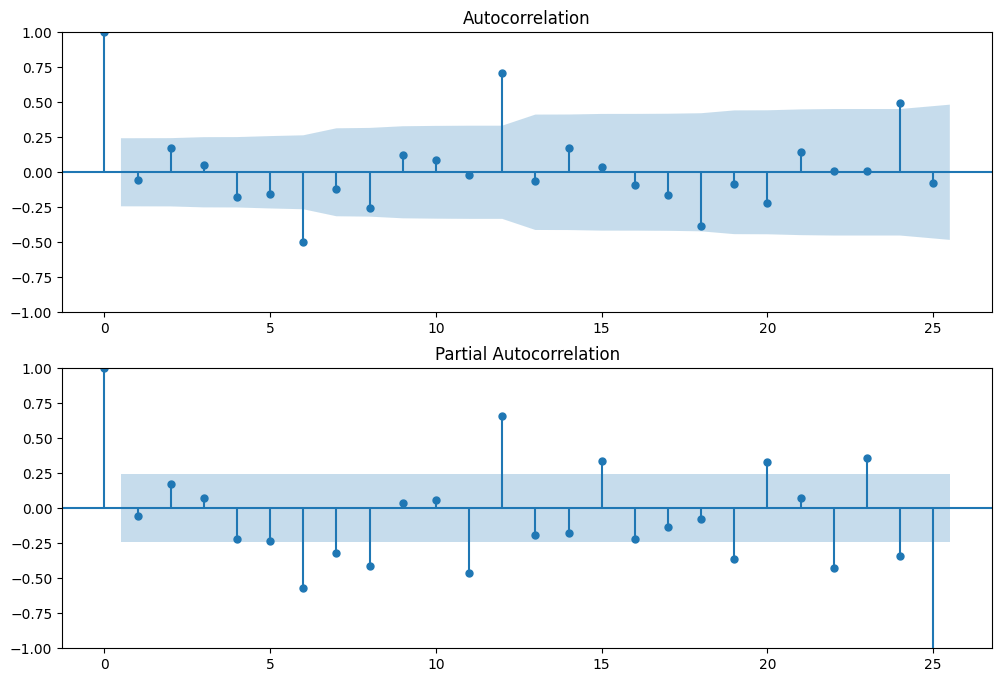

In [64]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otg2diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otg2diff, lags=25, ax=ax2)

In [65]:
otg2diff = otg2diff.diff(periods=12).dropna()

In [115]:
test1 = sm.tsa.adfuller(otg2diff)
print('adf: ', test1[0])
print('p-value: ', test1[1])
print('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']:
    print('not stationary')
else:
    print('stationary')

adf:  -6.077815499901385
p-value:  1.1106379762597666e-07
Critical values:  {'1%': -3.562878534649522, '5%': -2.918973284023669, '10%': -2.597393446745562}
stationary


#Model SARIMAX, product 2

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

lst = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_reg2, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit(disp=0)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
          continue

print(lst)

In [ ]:
model_21 = sm.tsa.statespace.SARIMAX(df_reg2,
                                  order=(0, 1, 1),
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results_21 = model_21.fit(disp=0)
print(results_21.summary().tables[1])

In [ ]:
results_21.plot_diagnostics(figsize=(16, 8))
plt.show()

#Compare

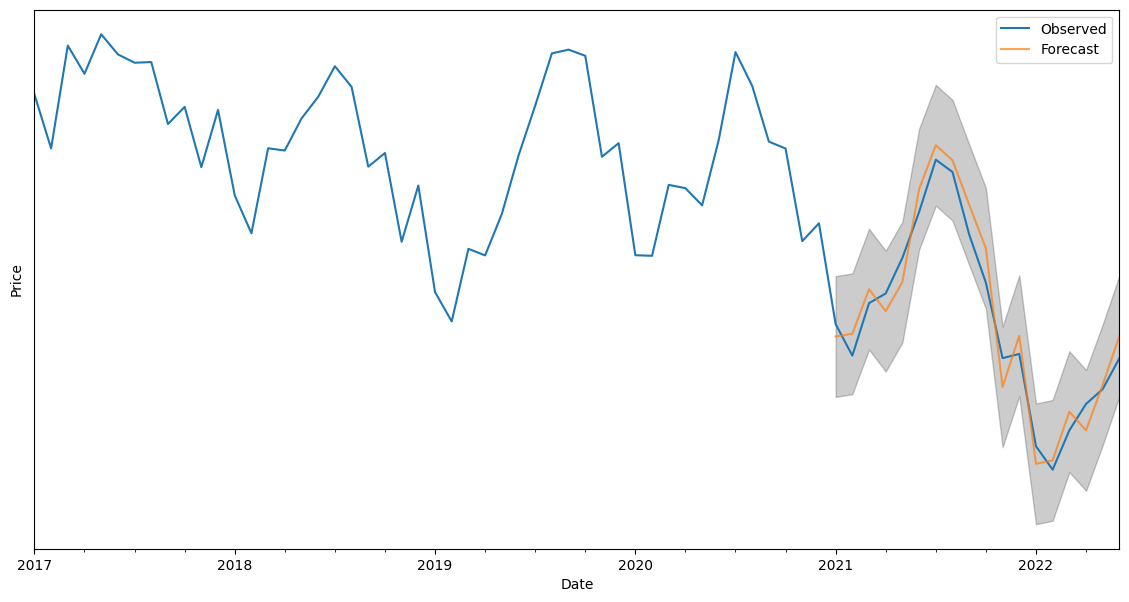

<Figure size 640x480 with 0 Axes>

In [70]:
pred_21 = results_21.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred_21.conf_int()
ax = df_reg2['2017':].plot(label='Observed')
pred_21.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.yticks([])
plt.legend()
plt.show()
plt.savefig("r_21_comp.png")

#Metrics

In [71]:
y_forecasted = pred_21.predicted_mean
y_truth = df_reg2['2021-01-01':]

mse_model_21 = mean_squared_error(y_forecasted, y_truth)
print('MSE: {}'.format(mse_model_21))

rmse_model_21 = mean_squared_error(y_forecasted, y_truth, squared=False)
print('RMSE: {}'.format(rmse_model_21))

r2_model_21 = r2_score(y_truth, y_forecasted)
print("R2: {}".format(r2_model_21))

MSE: 19159123882.665283
RMSE: 138416.4870333924
R2: 0.9446236226736107


#Forecast

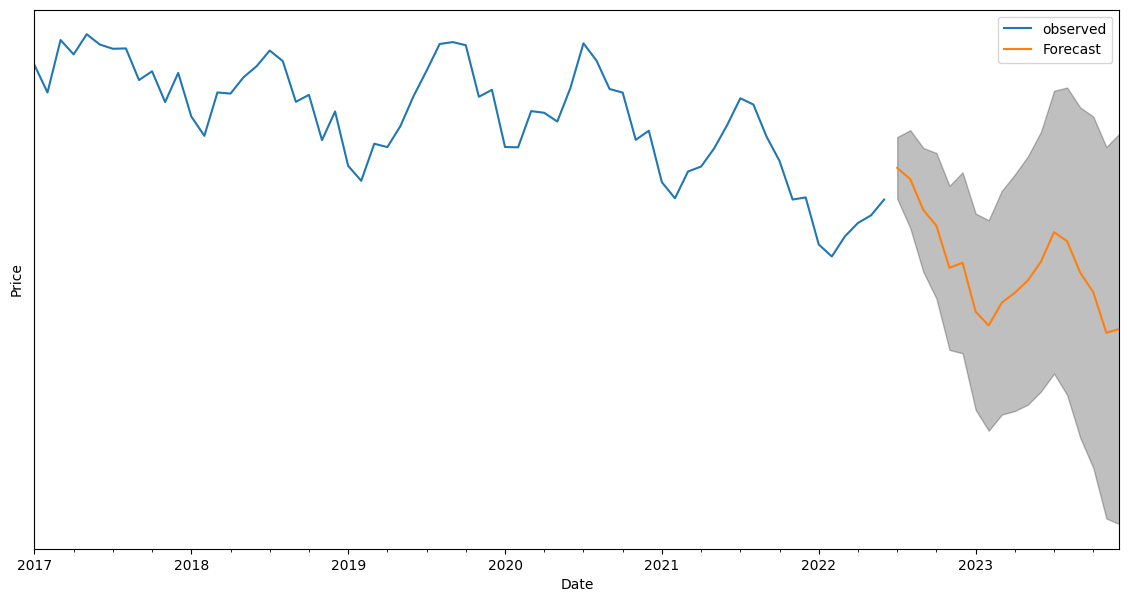

<Figure size 640x480 with 0 Axes>

In [82]:
pred_uc = results_21.get_forecast(steps=18)
pred_ci = pred_uc.conf_int()
ax = df_reg2.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.yticks([])
plt.legend()
plt.show()
plt.savefig("r_21_pred.png")

#Model Prophet, product 2

In [83]:
df_reg2_pr = df[df["Product"] == "product 2"][["MM.YYYY", "Price"]]

In [84]:
df_reg2_pr = df_reg2_pr.rename(columns={'MM.YYYY': 'ds', 'Price': 'y'})
model_22 = Prophet(interval_width=0.95)
model_22.fit(df_reg2_pr)

forecast_22 = model_22.make_future_dataframe(periods=18, freq='MS')
forecast_22 = model_22.predict(forecast_22)

18:34:23 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1800x600 with 0 Axes>

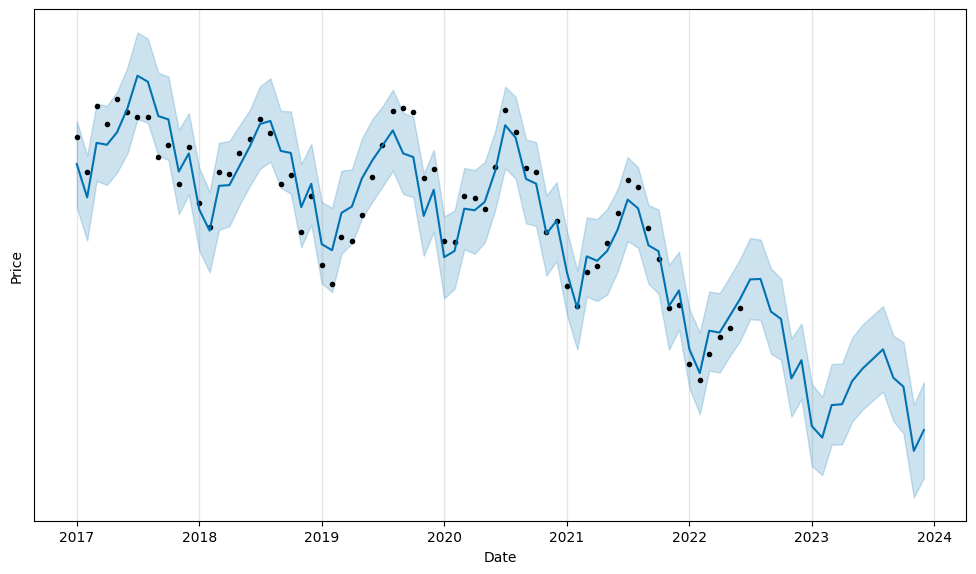

In [85]:
plt.figure(figsize=(18, 6))
model_22.plot(forecast_22, xlabel = 'Date', ylabel = 'Price')
plt.yticks([])
plt.savefig("r_22_pred.png")

#Compare

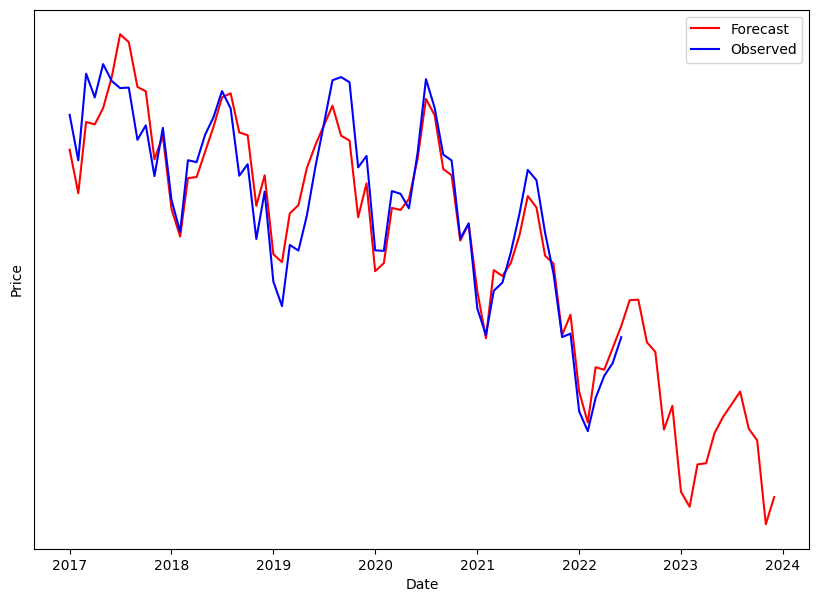

In [80]:
plt.figure(figsize=(10, 7))
plt.plot(forecast_22['ds'], forecast_22['yhat'], 'r-', label='Forecast')
plt.plot(df_reg2_pr['ds'],df_reg2_pr['y'], 'b-', label='Observed')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Price')
plt.yticks([])
plt.savefig("r_22_comp.png")

#Metrics

In [77]:
metric_df_22 = forecast_22.set_index('ds')[['yhat']].join(df_reg2_pr.set_index('ds').y).reset_index()
metric_df_22.dropna(inplace=True)
mse_model_22 = mean_squared_error(metric_df_22.y, metric_df_22.yhat)
print('MSE: {}'.format(mse_model_22))

MSE: 46198750653.58893


In [78]:
rmse_model_22 = mean_squared_error(metric_df_22.y, metric_df_22.yhat, squared=False)
print('RMSE: {}'.format(rmse_model_22))

RMSE: 214938.9463396267


In [79]:
r2_model_22 = r2_score(metric_df_22.y, metric_df_22.yhat)
print('R2: {}'.format(r2_model_22))

R2: 0.9135912625858885


#Product 3

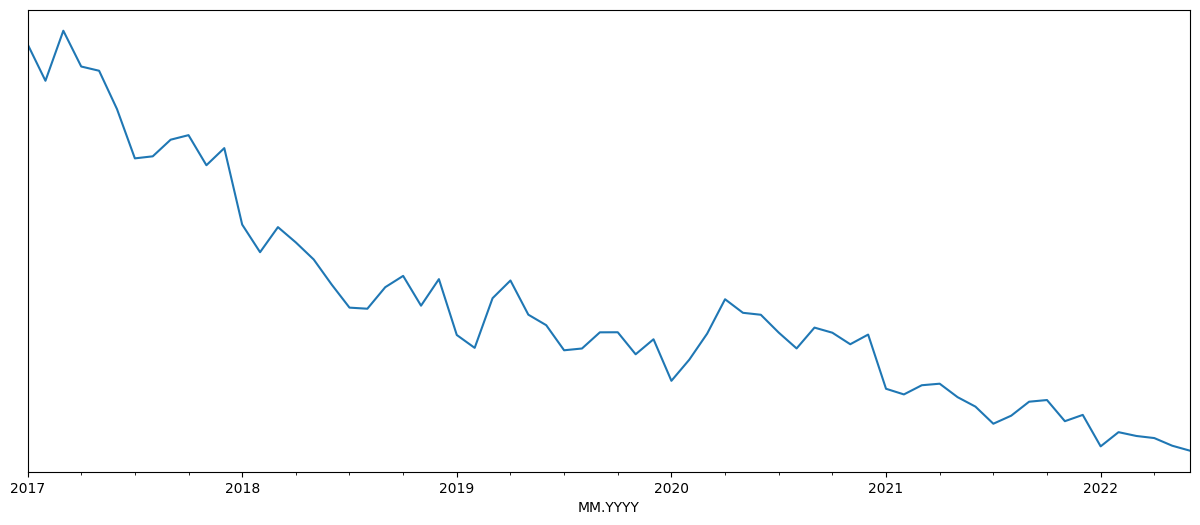

<Figure size 640x480 with 0 Axes>

In [86]:
df_reg3.plot(figsize=(15, 6))
plt.yticks([])
plt.show()
plt.savefig("r_31.png")

In [ ]:
decomposition = sm.tsa.seasonal_decompose(df_reg3, model='additive')
fig = decomposition.plot()
plt.show()
plt.savefig("r_31_decomp.png")

In [114]:
test = sm.tsa.adfuller(df_reg3)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']:
    print('not stationary')
else:
    print('stationary')

adf:  -3.3673886141104674
p-value:  0.012122118483198201
Critical values:  {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}
stationary


<AxesSubplot: xlabel='MM.YYYY'>

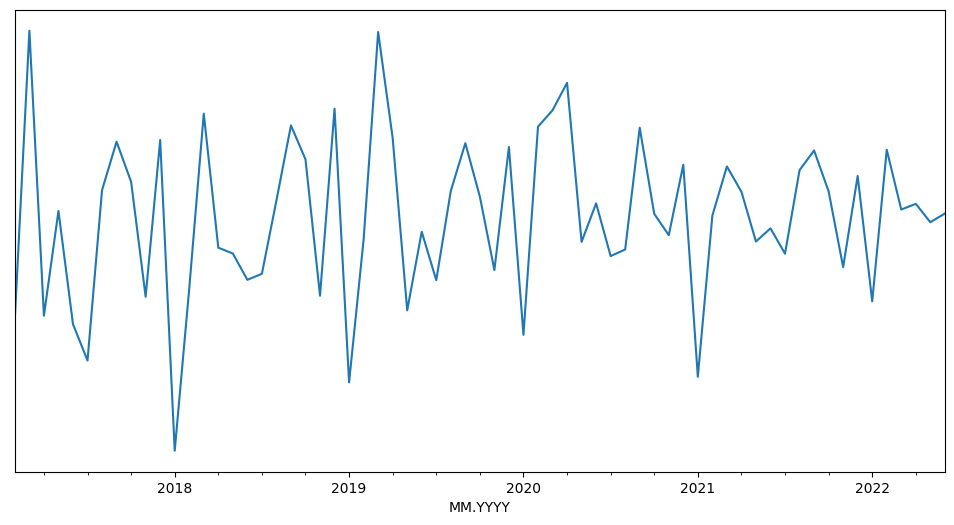

In [99]:
otg3diff = df_reg3.diff(periods=1).dropna()
plt.yticks([])
otg3diff.plot(figsize=(12, 6))

In [113]:
test = sm.tsa.adfuller(otg3diff)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0] > test[4]['5%']:
    print('not stationary')
else:
    print('stationary')

adf:  -1.7985778388918492
p-value:  0.38116798537431273
Critical values:  {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}
not stationary


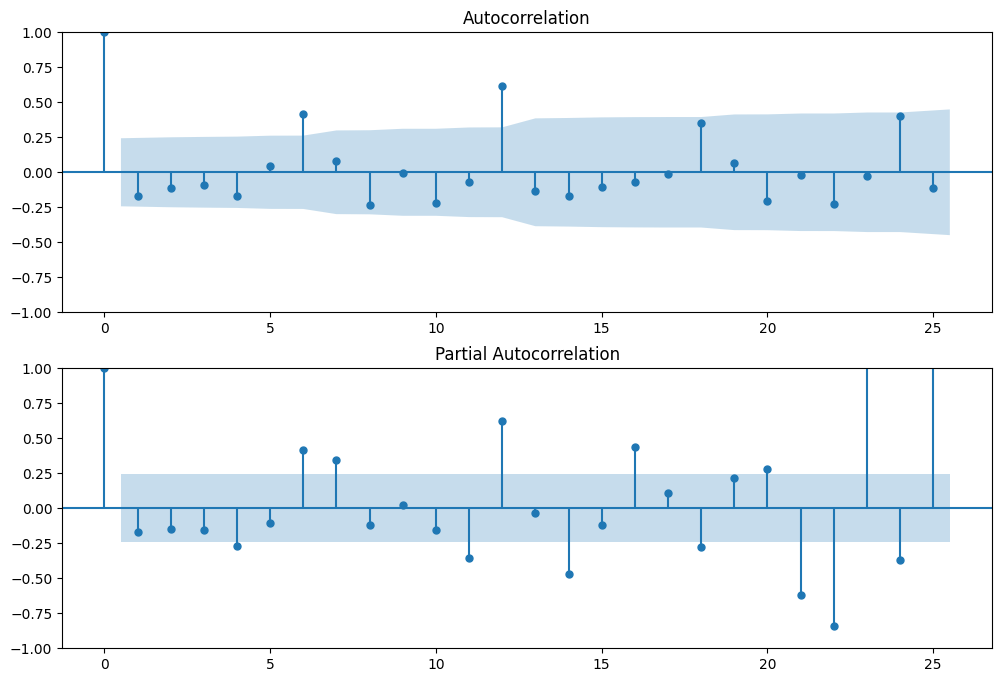

In [91]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otg3diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otg3diff, lags=25, ax=ax2)

In [92]:
otg3diff = otg3diff.diff(periods=6).dropna()

In [ ]:
test1 = sm.tsa.adfuller(otg3diff)
print('adf: ', test1[0])
print('p-value: ', test1[1])
print('Critical values: ', test1[4])
if test1[0] > test1[4]['5%']:
    print('not stationary')
else:
    print('stationary')

#Model SARIMAX, product 3

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]

lst = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_reg3, order=param, seasonal_order=param_seasonal,
                                            enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit(disp=0)
            print('ARIMA{}x{}6 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

print(lst)


In [ ]:
model_31 = sm.tsa.statespace.SARIMAX(df_reg3,
                                    order=(1, 1, 1),
                                    seasonal_order=(1, 1, 1, 6),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
results_31 = model_31.fit(disp=0)
print(results_31.summary().tables[1])

In [ ]:
results_31.plot_diagnostics(figsize=(16, 8))
plt.show()

#Compare

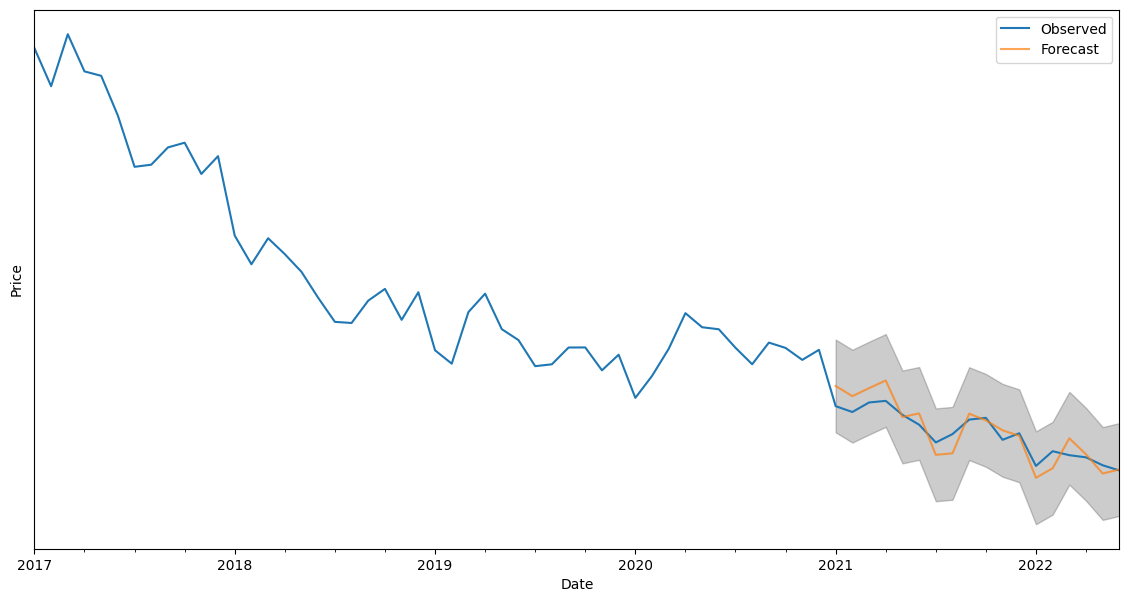

<Figure size 640x480 with 0 Axes>

In [100]:
pred_31 = results_31.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred_31.conf_int()
ax = df_reg3['2017':].plot(label='Observed')
pred_31.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.yticks([])

plt.legend()
plt.show()
plt.savefig("r_31_comp.png")

In [101]:
y_forecasted = pred_31.predicted_mean
y_truth = df_reg3['2021-01-01':]

mse_model_31 = mean_squared_error(y_forecasted, y_truth)
print('MSE: {}'.format(mse_model_31))

rmse_model_31 = mean_squared_error(y_forecasted, y_truth, squared=False)
print('RMSE: {}'.format(rmse_model_31))

r2_model_31 = r2_score(y_truth, y_forecasted)
print("R2: {}".format(r2_model_31))

MSE: 804058444529.8798
RMSE: 896693.0603778975
R2: 0.6816760249610867


#Forecast

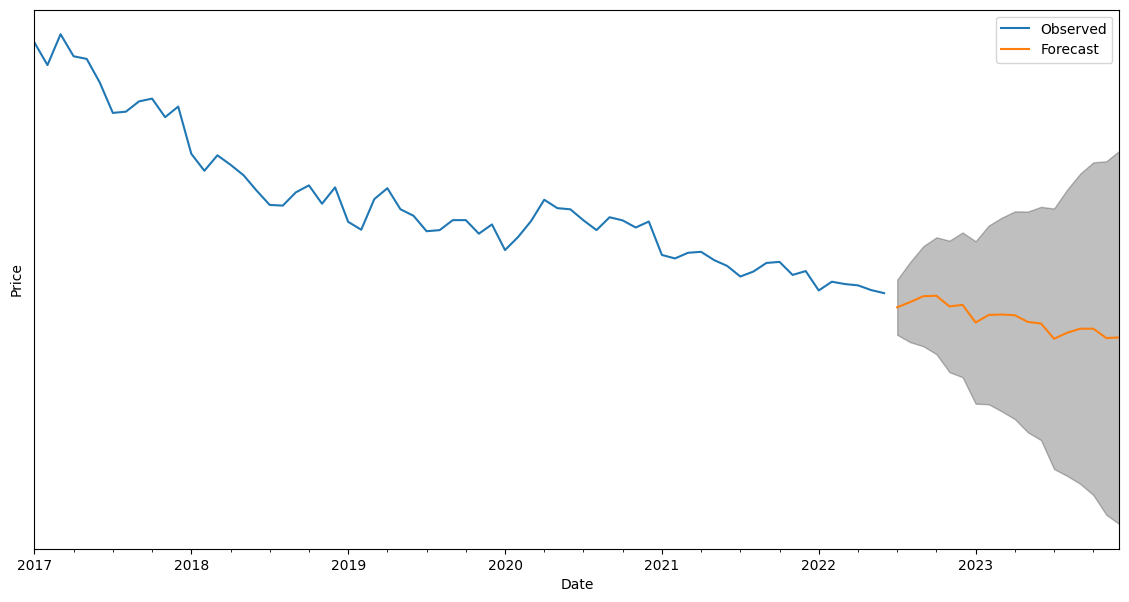

<Figure size 640x480 with 0 Axes>

In [102]:
pred_uc = results_31.get_forecast(steps=18)
pred_ci = pred_uc.conf_int()
ax = df_reg3.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.yticks([])
plt.legend()
plt.show()
plt.savefig("r_31_pred.png")

#Model Prophet, product 3

In [103]:
df_reg3_pr = df[df["Product"] == "product 3"][["MM.YYYY", "Price"]]

In [104]:
df_reg3_pr = df_reg3_pr.rename(columns={'MM.YYYY': 'ds', 'Price': 'y'})
model_32 = Prophet(interval_width=0.95)
model_32.fit(df_reg3_pr)

forecast_32 = model_32.make_future_dataframe(periods=18, freq='MS')
forecast_32 = model_32.predict(forecast_32)

18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing


#Forecast

<Figure size 1800x600 with 0 Axes>

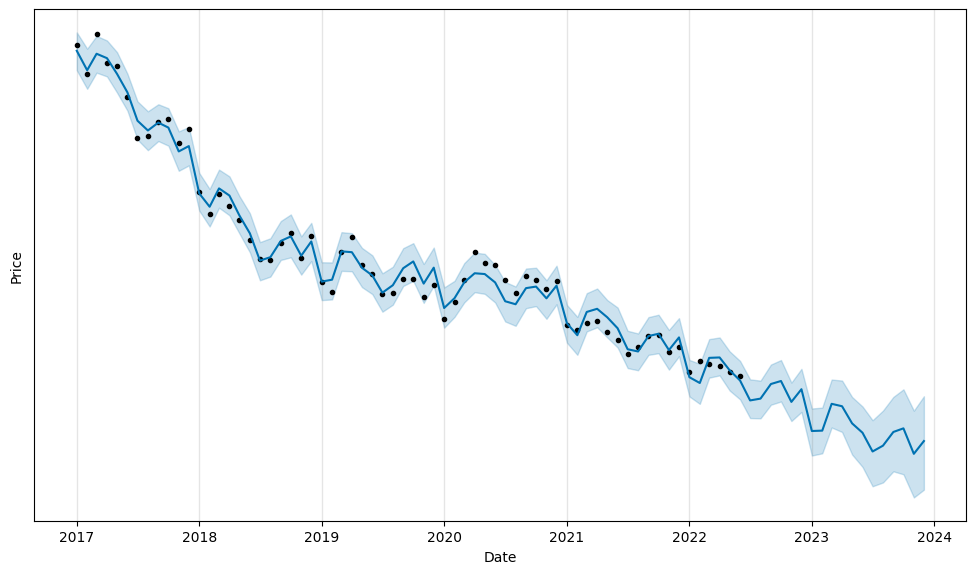

In [105]:
plt.figure(figsize=(18, 6))

model_32.plot(forecast_32, xlabel='Date', ylabel="Price")
plt.yticks([])
plt.savefig("r_32_pred.png")

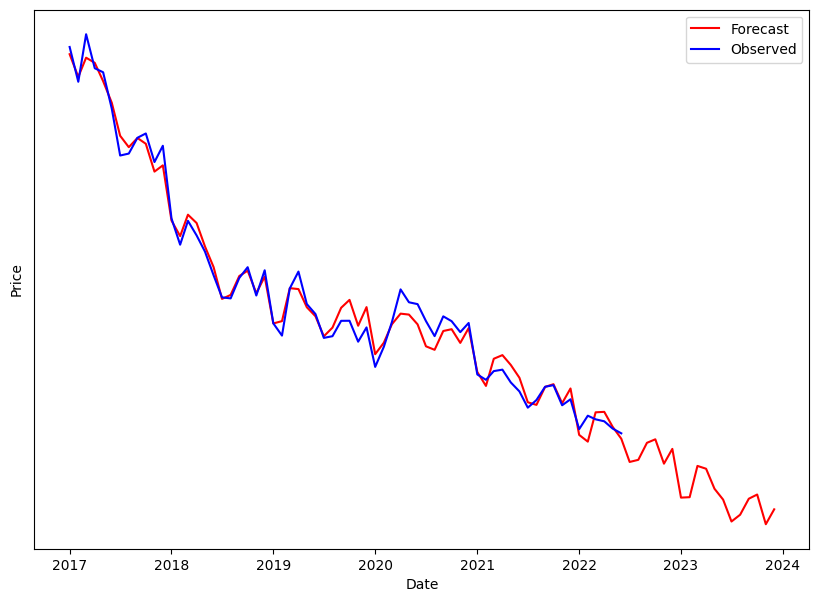

In [106]:
plt.figure(figsize=(10, 7))
plt.plot(forecast_32['ds'], forecast_32['yhat'], 'r-', label='Forecast')
plt.plot(df_reg3_pr['ds'], df_reg3_pr['y'], 'b-', label='Observed')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Price')
plt.yticks([])
plt.savefig("r_32_comp.png")

In [107]:
metric_df_32 = forecast_32.set_index('ds')[['yhat']].join(df_reg3_pr.set_index('ds').y).reset_index()
metric_df_32.dropna(inplace=True)

mse_model_32 = mean_squared_error(metric_df_32.y, metric_df_32.yhat)
print('MSE: {}'.format(mse_model_32))

MSE: 788907213941.7458


In [108]:
rmse_model_32 = mean_squared_error(metric_df_32.y, metric_df_32.yhat, squared=False)
print('RMSE: {}'.format(rmse_model_32))

RMSE: 888204.4888097255


In [109]:
r2_model_32  = r2_score(metric_df_32.y, metric_df_32.yhat)
print('R2: {}'.format(r2_model_32))

R2: 0.9875736120247417


#Summary

In [110]:
print(f"Product 1\nSARIMAX_MSE ={mse_model_11}; SARIMAX_RMSE = {rmse_model_11}; SARIMAX_R2 = {r2_model_11}\n Prophet_MSE ={mse_model_12}; Prophet_RMSE = {rmse_model_12}; Prophet_R2 = {r2_model_12}\n")

print(f"\nProduct 2\nSARIMAX_MSE ={mse_model_21}; SARIMAX_RMSE = {rmse_model_21}; SARIMAX_R2 = {r2_model_21}\n Prophet_MSE ={mse_model_22}; Prophet_RMSE = {rmse_model_22}; Prophet_R2 = {r2_model_22}\n")

print(f"\nProduct 3\nSARIMAX_MSE ={mse_model_31}; SARIMAX_RMSE = {rmse_model_31}; SARIMAX_R2 = {r2_model_31}\n Prophet_MSE ={mse_model_32}; Prophet_RMSE = {rmse_model_32}; Prophet_R2 = {r2_model_32}\n")

Product 1
SARIMAX_MSE =182566982950.17502; SARIMAX_RMSE = 427278.5776869407; SARIMAX_R2 = 0.8233032943652043
 Prophet_MSE =630965580360.1533; Prophet_RMSE = 794333.4188866494; Prophet_R2 = 0.9594250205778208


Product 2
SARIMAX_MSE =19159123882.665283; SARIMAX_RMSE = 138416.4870333924; SARIMAX_R2 = 0.9446236226736107
 Prophet_MSE =46198750653.58893; Prophet_RMSE = 214938.9463396267; Prophet_R2 = 0.9135912625858885


Product 3
SARIMAX_MSE =804058444529.8798; SARIMAX_RMSE = 896693.0603778975; SARIMAX_R2 = 0.6816760249610867
 Prophet_MSE =788907213941.7458; Prophet_RMSE = 888204.4888097255; Prophet_R2 = 0.9875736120247417

